# IMPORTING LIBRARIES AND DATA

In [153]:
!pip install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier

In [154]:
data = yf.download("ABEV3.SA", period='30d',  interval = "2m")

[*********************100%***********************]  1 of 1 completed


In [155]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-10-07 10:08:00-03:00,13.43,13.46,13.42,13.43,13.43,0
2020-10-07 10:10:00-03:00,13.44,13.57,13.43,13.55,13.55,419800
2020-10-07 10:12:00-03:00,13.55,13.62,13.55,13.61,13.61,209300
2020-10-07 10:14:00-03:00,13.61,13.63,13.60,13.62,13.62,343400
2020-10-07 10:16:00-03:00,13.62,13.64,13.61,13.62,13.62,552500
...,...,...,...,...,...,...
2020-11-19 15:50:00-03:00,14.70,14.70,14.69,14.70,14.70,21300
2020-11-19 15:52:00-03:00,14.70,14.70,14.68,14.68,14.68,62500
2020-11-19 15:54:00-03:00,14.68,14.70,14.68,14.70,14.70,227800


# PREPARING DAY TEST DF

In [156]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-10-07 10:08:00-03:00,13.43,13.46,13.42,13.43,13.43,0
2020-10-07 10:10:00-03:00,13.44,13.57,13.43,13.55,13.55,419800
2020-10-07 10:12:00-03:00,13.55,13.62,13.55,13.61,13.61,209300
2020-10-07 10:14:00-03:00,13.61,13.63,13.60,13.62,13.62,343400
2020-10-07 10:16:00-03:00,13.62,13.64,13.61,13.62,13.62,552500
...,...,...,...,...,...,...
2020-11-19 15:50:00-03:00,14.70,14.70,14.69,14.70,14.70,21300
2020-11-19 15:52:00-03:00,14.70,14.70,14.68,14.68,14.68,62500
2020-11-19 15:54:00-03:00,14.68,14.70,14.68,14.70,14.70,227800


In [157]:
df = data
df = df.drop(['High', 'Low', 'Adj Close', 'Open'],axis=1)

# Creating t-n columns for Close
for i in range(1,28):
    df['Close_Minus{}'.format(i)] = df['Close'].shift(i)

# Creating t-n columns for Volume    
for i in range(1,28):
    df['Volume_Minus{}'.format(i)] = df['Volume'].shift(i)

df = df.loc['2020-11-03 10:00:00-03:00':'2020-11-03 16:50:00-03:00']

# TRAIN/TEST MODEL

## Data preprocessing

In [158]:
# Feature engineering
bvsp = data
bvsp = bvsp[['Close', 'Volume']]
bvsp = bvsp.loc[:'2020-10-30 16:50:00-03:00']

# Creating t-n columns for Close
for i in range(1,28):
    bvsp['Close_Minus{}'.format(i)] = bvsp['Close'].shift(i)

# Creating t-n columns for Volume    
for i in range(1,28):
    bvsp['Volume_Minus{}'.format(i)] = bvsp['Volume'].shift(i)


bvsp_ann = bvsp.dropna() # dropping NAs

bvsp_ann['Rise'] = 1
periods_ahead = 24 # 1 and a half hours
positive_variation = 1.02

for i in range(1,len(bvsp_ann)-periods_ahead):
    for j in range(1,periods_ahead):
        if bvsp_ann['Close'].iloc[i]/bvsp_ann['Close'].iloc[i+j] > positive_variation:
            bvsp_ann['Rise'].iloc[i] = 1
            break
        else:
            bvsp_ann['Rise'].iloc[i] = 0

bvsp_ann = bvsp_ann.iloc[:-periods_ahead]

In [160]:
bvsp_ann['Rise'].value_counts()

0    3061
1      71
Name: Rise, dtype: int64

In [161]:
# Splitting into subsets
X = bvsp_ann.drop('Rise', axis=1)
y = bvsp_ann['Rise']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Scaling data
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating Early Stop callback
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

# Building the model
model = Sequential()
model.add(Dense(units=56,activation='relu'))
model.add(Dense(units=28,activation='relu'))
model.add(Dense(units=14,activation='relu'))
model.add(Dense(units=8,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])

# Fitting the model
model.fit(x=X_train, 
          y=y_train.values,
          epochs=2000, verbose=0.1,
         validation_data=(X_train,y_train.values),
         callbacks=[early_stop])

Epoch 1/2000
Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68/2000
Epoch 69/2000
Epoch 70/2000
Epoch 71/2000
Epoch 72/2000
E

In [162]:
# Getting loss and accuracy plot
model_loss = pd.DataFrame(model.history.history)
#model_loss.plot()

# Getting predictions metrics
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       921
           1       0.00      0.00      0.00        19

    accuracy                           0.98       940
   macro avg       0.49      0.50      0.49       940
weighted avg       0.96      0.98      0.97       940

[[921   0]
 [ 19   0]]


# SHOW TIME

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras

model = keras.models.load_model(r"C:\Users\rodrigo\Documents\Python\ml-financial-market\models\saved_model.pb")
df = pd.read_csv(r"C:\Users\rodrigo\Documents\Python\ml-financial-market\data\interim\interim_for_portfolio.csv")
X_test = pd.read_csv(r'C:\Users\rodrigo\Documents\Python\ml-financial-market\data\processed\portfolio.csv')


portfolio = pd.DataFrame(index=df.index, columns=['position', 'stocks_owned', 'bank'])
portfolio['position'] = 'Sold'
portfolio['bank'] = 10000
portfolio['stocks_owned'] = 0
portfolio['Model Recommendation'] = 0
portfolio['Close'] = df['close']
portfolio.head()

price_bought = 0

for i in range(len(portfolio)-1):
	buy_or_not = model.predict_classes(X_test[i])
	portfolio['Model Recommendation'].iloc[i] = buy_or_not
	if portfolio['position'].iloc[i] == 'Sold':
		if buy_or_not == 1:
			portfolio['stocks_owned'].iloc[i+1] = int(portfolio['bank'].iloc[i]/portfolio['Close'].iloc[i])
			portfolio['bank'].iloc[i+1] = (portfolio['bank'].iloc[i] % portfolio['Close'].iloc[i])
			portfolio['position'].iloc[i+1] = 'Bought'
			price_bought = portfolio['Close'].iloc[i]
			print('Comprou por {}'.format(price_bought))
		else:
			portfolio['position'].iloc[i+1] = portfolio['position'].iloc[i]
			portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i]
			portfolio['stocks_owned'].iloc[i+1] = portfolio['stocks_owned'].iloc[i]
			print('Não comprou')
	elif portfolio['Close'].iloc[i] < (0.95) * price_bought:
		portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i] + portfolio['Close'].iloc[i] * portfolio['stocks_owned'].iloc[i]
		portfolio['stocks_owned'].iloc[i+1] = 0
		portfolio['position'].iloc[i+1] = 'Sold'
		print("Vendeu por {}".format(portfolio['Close'].iloc[i]))
	elif portfolio['Close'].iloc[i] > positive_variation * price_bought:
		portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i] + portfolio['Close'].iloc[i] * portfolio['stocks_owned'].iloc[i]
		portfolio['stocks_owned'].iloc[i+1] = 0
		portfolio['position'].iloc[i+1] = 'Sold'
		print("Vendeu por {}".format(portfolio['Close'].iloc[i]))
	else:
		portfolio['position'].iloc[i+1] = portfolio['position'].iloc[i]
		portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i]
		portfolio['stocks_owned'].iloc[i+1] = portfolio['stocks_owned'].iloc[i]
		print("Não vendeu.")

portfolio['Total$'] = portfolio['stocks_owned'] * portfolio['Close'] + portfolio['bank']
portfolio['Total$'].describe()

OSError: SavedModel file does not exist at: C:\Users\rodrigo\Documents\Python\ml-financial-market\models\saved_model.pb/{saved_model.pbtxt|saved_model.pb}

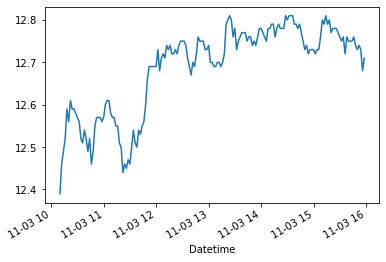

In [147]:
portfolio['Close'].plot()

In [15]:
import pandas as pd
import numpy as np
from tensorflow import keras

model = keras.models.load_model(r'C:\Users\rodrigo\Documents\ml-financial-market\ml-financial-market\models')
df = pd.read_csv(r'C:\Users\rodrigo\Documents\ml-financial-market\ml-financial-market\data\interim\interim.csv')
X_test = pd.read_csv(r'C:\Users\rodrigo\Documents\ml-financial-market\ml-financial-market\data\processed\X_test.csv')

# portfolio = pd.DataFrame(index=df.index, columns=['position', 'stocks_owned', 'bank'])
# portfolio['position'] = 'Sold'
# portfolio['bank'] = 10000
# portfolio['stocks_owned'] = 0
# portfolio['Model Recommendation'] = 0
# portfolio['close'] = df['close']
# portfolio.head()

# price_bought = 0

# positive_variation = 0.02

In [17]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.735294,0.001375,0.744479,0.731511,0.735016,0.750395,0.732463,0.728732,0.733438,0.735016,...,0.038272,0.002921,0.003373,0.005635,0.007766,0.081887,0.010742,0.012209,0.016701,0.005741
1,0.307190,0.001699,0.324921,0.319936,0.329653,0.330174,0.309951,0.319422,0.332808,0.332808,...,0.005233,0.002856,0.001787,0.000930,0.001425,0.005546,0.001943,0.002080,0.008454,0.003148
2,0.777778,0.006250,0.785489,0.776527,0.796530,0.786730,0.776509,0.791332,0.793375,0.790221,...,0.006083,0.004088,0.003858,0.005415,0.011693,0.049271,0.015866,0.017330,0.107363,0.016469
3,0.299020,0.004466,0.321767,0.315112,0.331230,0.328594,0.309951,0.325843,0.335962,0.342271,...,0.011975,0.005444,0.004021,0.007327,0.004957,0.059048,0.014127,0.006997,0.032975,0.004930
4,0.383987,0.005351,0.405363,0.418006,0.422713,0.431280,0.399674,0.399679,0.411672,0.411672,...,0.035993,0.002570,0.007262,0.004202,0.012587,0.055506,0.014517,0.021832,0.109029,0.024862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,0.303922,0.003415,0.320189,0.307074,0.312303,0.314376,0.290375,0.304976,0.315457,0.313880,...,0.020417,0.004339,0.004443,0.002602,0.006113,0.012444,0.004718,0.004047,0.045073,0.008718
1370,0.434640,0.002040,0.452682,0.443730,0.444795,0.454976,0.433932,0.436597,0.447950,0.447950,...,0.053468,0.021310,0.003007,0.003878,0.005848,0.042926,0.009116,0.012251,0.027611,0.010535
1371,0.294118,0.015343,0.321767,0.292604,0.305994,0.278041,0.265906,0.255217,0.252366,0.255521,...,0.010935,0.004443,0.002353,0.004546,0.035938,0.013636,0.002288,0.003250,0.023042,0.002314
1372,0.767974,0.003264,0.783912,0.774920,0.780757,0.783570,0.786297,0.797753,0.802839,0.801262,...,0.009126,0.002521,0.000731,0.002045,0.000878,0.011662,0.003321,0.001195,0.012309,0.001128


# ALL TOGETHER


In [45]:
day_to_analyze = '2020-10-18' + '10:00:00-03:00'
day_to_analyze[:10]

'2020-10-18'

In [18]:
!pip install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier

ERROR: yahooquery 2.2.8 has requirement lxml==4.5.0, but you'll have lxml 4.6.1 which is incompatible.
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22622 sha256=e366f0455488032447805c266824a1233e2a3128468f6306246bee9a9df80e19
  Stored in directory: c:\users\rodrigo\appdata\local\pip\cache\wheels\b4\c3\39\9c01ae2b4726f37024bba5592bec868b47a2fab5a786e8979a
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8374 sha256=cdc7d0bacb097f054a3e291b82745b60029cccca05b658a102cdbdbbddb70815
  Stored in directory: c:\users\rodrigo\appdata\local\pip\cache\wheels\57\6d\a3\a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.0
    Uninstalling lxml-4.5.0:
      Successfully uninstalled lxml-4.5.0


In [11]:
data = yf.download("PETR4.SA", period='30d',  interval = "2m")

df = data
df = df.drop(['High', 'Low', 'Adj Close', 'Open'],axis=1)

day_to_analyze = '2020-10-19'
day_start = day_to_analyze + ' 10:00:00-03:00'
day_end = day_to_analyze + ' 16:50:00-03:00'

bvsp = bvsp.loc[:'2020-10-19 16:50:00-03:00']

bvsp_ann = bvsp.dropna() # dropping NAs

bvsp_ann['Rise'] = 1
periods_ahead = 180 # 1 and a half hours
positive_variation = 1.02

for i in range(1,len(bvsp_ann)-periods_ahead):
    for j in range(1,periods_ahead):
        if bvsp_ann['Close'].iloc[i]/bvsp_ann['Close'].iloc[i+j] > positive_variation:
            bvsp_ann['Rise'].iloc[i] = 1
            break
        else:
            bvsp_ann['Rise'].iloc[i] = 0

bvsp_ann = bvsp_ann.iloc[:-periods_ahead]


# Splitting into subsets
X = bvsp_ann.drop('Rise', axis=1)
y = bvsp_ann['Rise']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Scaling data
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating Early Stop callback
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=15)

# Building the model
model = Sequential()
model.add(Dense(units=28,activation='relu'))
model.add(Dense(units=22,activation='relu'))
model.add(Dense(units=15,activation='relu'))
model.add(Dense(units=10,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])

# Fitting the model
model.fit(x=X_train, 
          y=y_train.values,
          epochs=2000, verbose=1,
         validation_data=(X_train,y_train.values),
         callbacks=[early_stop])

portfolio = pd.DataFrame(columns=['position', 'stocks_owned', 'bank'])
portfolio['position'] = 'Sold'
portfolio['bank'] = 10000
portfolio['stocks_owned'] = 0
portfolio['Model Recommendation'] = 0
portfolio['Close'] = bvsp_ann['Close']
portfolio.head()

price_bought = 0

for i in range(len(portfolio)-1):
	buy_or_not = model.predict_classes(np.array([df[i],]))[0][0]
	portfolio['Model Recommendation'].iloc[i] = buy_or_not
	if portfolio['position'].iloc[i] == 'Sold':
		if buy_or_not == 1:
			portfolio['stocks_owned'].iloc[i+1] = int(portfolio['bank'].iloc[i]/portfolio['Close'].iloc[i])
			portfolio['bank'].iloc[i+1] = (portfolio['bank'].iloc[i] % portfolio['Close'].iloc[i])
			portfolio['position'].iloc[i+1] = 'Bought'
			price_bought = portfolio['Close'].iloc[i]
			print('Comprou por {}'.format(price_bought))
		else:
			portfolio['position'].iloc[i+1] = portfolio['position'].iloc[i]
			portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i]
			portfolio['stocks_owned'].iloc[i+1] = portfolio['stocks_owned'].iloc[i]
			print('Não comprou')
	elif portfolio['Close'].iloc[i] < (0.95) * price_bought:
		portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i] + portfolio['Close'].iloc[i] * portfolio['stocks_owned'].iloc[i]
		portfolio['stocks_owned'].iloc[i+1] = 0
		portfolio['position'].iloc[i+1] = 'Sold'
		print("Vendeu por {}".format(portfolio['Close'].iloc[i]))
	elif portfolio['Close'].iloc[i] > positive_variation * price_bought:
		portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i] + portfolio['Close'].iloc[i] * portfolio['stocks_owned'].iloc[i]
		portfolio['stocks_owned'].iloc[i+1] = 0
		portfolio['position'].iloc[i+1] = 'Sold'
		print("Vendeu por {}".format(portfolio['Close'].iloc[i]))
	else:
		portfolio['position'].iloc[i+1] = portfolio['position'].iloc[i]
		portfolio['bank'].iloc[i+1] = portfolio['bank'].iloc[i]
		portfolio['stocks_owned'].iloc[i+1] = portfolio['stocks_owned'].iloc[i]
		print("Não vendeu.")

portfolio['Total$'] = portfolio['stocks_owned'] * portfolio['Close'] + portfolio['bank']
portfolio['Total$'].describe()

portfolio.tail()

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Epoch 1/2000
89/89 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.6365 - val_loss: 0.6747 - val_accuracy: 0.6510
Epoch 2/2000
89/89 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.6599 - val_loss: 0.6234 - val_accuracy: 0.6929
Epoch 3/2000
89/89 [==============================] - 0s 2ms/step - loss: 0.5989 - accuracy: 0.6645 - val_loss: 0.5807 - val_accuracy: 0.6869
Epoch 4/2000
89/89 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.6695 - val_loss: 0.5705 - val_accuracy: 0.6606
Epoch 5/2000
89/89 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.6720 - val_loss: 0.5656 - val_accuracy: 0.6901
Epoch 6/2000
89/89 [==============================] - 0s 2ms/step - loss: 0.5736 - accuracy: 0.6826 - val_loss: 0.5767 - val_accuracy: 0.7359
Epoch 7/2000
89/89 [==============================] - 0s 2ms/step - loss: 0.5641 - accuracy: 0.6716 - val_loss: 0.5611 - val_accuracy: 0.6624
Epoch 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


ValueError: ignored